# QC filtering

This notebook is about filtering scATAC seq data within an adata object to archive a good quality peak matrix.
For this task various QC filters are implemented. The latter includes filters related to:

- doublet score
- number of features per barcode
- mean insert size
- promotor enrichment


## Settings

In [ ]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/ext_ana/processed' # specify the output directory of the processing should be the same in every notebook
test = 'all' # sample name, this should be the same for all the notebooks

## QC Settings

In [ ]:
# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "Sample"

# Data inspection
# Set True if the insertsize distribution should be plotted
# If there is no insertsize distribution set this False
plot_insertsize_dist = True

filter_xy = True  # True or False; filtering out chrX and chrY
binarize_mtx = True  # True or False; convert matrix to binary

############################# filters ##########################################

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = False

# Filter to use:
n_features_filter = True # True or False; filtering out cells with numbers of features not in the range defined below
mean_insertsize_filter = True # True or False; filtering out cells with mean insertsize not in the range defined below
filter_pct_fp= True # True or False; filtering out cells with promotor_enrichment not in the range defined below
filter_chrM_fragments= False # True or False; filtering out cells with a number features in chromosome M not in the defined range
filter_uniquely_mapped_fragments= False # True or False; filtering out cells with fragments mapped not in the defined range


# if this is True thresholds below are ignored 
only_automatic_thresholds = False # True or False; to use automatic thresholds

############################# set default values #######################################
# 
# This will be applied to all samples the thresholds can be changed manually when plotted 
# if thresholds None they are set automatically

# default values n_features 
min_features = 100
max_features = 5000

# default mean_insertsize
upper_threshold_mis=None
lower_threshold_mis=None

# default promotor enrichment
upper_threshold_pct_fp=None
lower_threshold_pct_fp=None

# default number of fragments
upper_thr_fragments=None
lower_thr_fragments=None

# default number of fragments in chrM
upper_thr_chrM_fragments=1000
lower_thr_chrM_fragments=0

# default number of uniquely mapped fragments
upper_thr_um=20000
lower_thr_um=0



## Sum up settings

In [ ]:
manual_thresholds = {}
if n_features_filter:
    manual_thresholds['n_features_by_counts'] = {'min' : min_features, 'max' : max_features}

if mean_insertsize_filter:
    manual_thresholds['mean_insertsize'] = {'min' : lower_threshold_mis, 'max' : upper_threshold_mis}

if filter_pct_fp:
    manual_thresholds['pct_fragments_in_promoters'] = {'min' : lower_threshold_pct_fp, 'max' : upper_threshold_pct_fp}

if filter_chrM_fragments:
    manual_thresholds['CM'] = {'min' : lower_thr_chrM_fragments, 'max' : upper_thr_chrM_fragments}

if filter_uniquely_mapped_fragments:
    manual_thresholds['UM'] = {'min' : lower_thr_um, 'max' : upper_thr_um}

obs_columns = list(manual_thresholds.keys())

## Loading packages and setup

In [ ]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
from sctoolbox.plotting import *
from sctoolbox.atac_utils import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
import numpy as np

## Setup path handling object 

In [ ]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

## Load anndata 

In [ ]:
# probably updated in future
assembling_output = tree.assembled_anndata
adata = epi.read_h5ad(assembling_output)
adata

In [ ]:
adata.var

In [69]:
if plot_insertsize_dist:
    atac.plot_insertsize(adata)

# QC

## 1. filtering out chrX, chrY and chrM

In [ ]:
non_m = [name for name in adata.var_names if not name.startswith('chrM')]  # remove chrM
adata = adata[:, non_m]

In [ ]:
if filter_xy:
    non_xy = [name for name in adata.var_names if not name.startswith('chrY') | name.startswith('chrX')]
    adata = adata[:, non_xy]

In [ ]:
display(adata)

## 2. removing empty cells

In [ ]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

## 3. binarize

In [ ]:
adata.raw = adata
if binarize_mtx:
    epi.pp.binarize(adata)
    adata.layers['binary'] = adata.X.copy()

## 5. visualize adata

In [ ]:
adata.var

In [ ]:
# plot_ov_hist(adata, threshold_features=50) 
epi.pp.filter_features(adata, min_cells=1)
epi.pp.filter_cells(adata, min_features=1)
epi.pp.coverage_cells(adata, binary=True, log=False, bins=50)
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50)

epi.pp.coverage_features(adata, binary=True, log=False, bins=50)
epi.pp.coverage_features(adata, binary=True, log=10, bins=50)

## 6. Cells Filtering

### 6.1 get thresholds dict

In [ ]:
# groupby = condition_column if global_threshold is False else None
# default_thresholds = build_default_thresholds(adata, manual_thresholds, groupby)
# default_thresholds

In [ ]:
adata.raw = adata
if binarize_mtx:
    epi.pp.binarize(adata)
    adata.layers['binary'] = adata.X.copy()

## 5. visualize adata

In [ ]:
adata.var

In [ ]:
# plot_ov_hist(adata, threshold_features=50) 
epi.pp.filter_features(adata, min_cells=1)
epi.pp.filter_cells(adata, min_features=1)
epi.pp.coverage_cells(adata, binary=True, log=False, bins=50)
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50)

epi.pp.coverage_features(adata, binary=True, log=False, bins=50)
epi.pp.coverage_features(adata, binary=True, log=10, bins=50)

## 6. Cells Filtering

### 6.1 get thresholds dict

In [ ]:
groupby = condition_column if global_threshold is False else None
thresholds = get_thresholds_atac_wrapper(adata, manual_thresholds, only_automatic_thresholds, groupby=groupby)
thresholds_as_table(thresholds)

### 6.2 plot thresholds

In [ ]:
epi.pp.coverage_cells(adata, binary=True, log=False, bins=50)

In [ ]:
# Get final thresholds
final_thresholds = get_slider_thresholds(obs_slider_dict)
thresholds_as_table(final_thresholds) # show thresholds

### 6.3 filter adata

In [56]:
apply_qc_thresholds(adata, final_thresholds, groupby=groupby)
# remove empty features
epi.pp.filter_features(adata, min_cells=1)

Filtering based on 'n_features_by_counts' from 80317 -> 62886 cells
Filtering based on 'mean_insertsize' from 62886 -> 59693 cells
Filtering based on 'pct_fragments_in_promoters' from 59693 -> 53819 cells


In [57]:
# log-convert number of features
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
display(adata)

AnnData object with n_obs × n_vars = 53819 × 145907
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_fragments_in_promoters', 'n_total_fragments', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'gene_start', 'gene_end', 'gene_strand', 'gene_anchor', 'distance_to_gene', 'relative_location_to_gene', 'gene_ovl_peak', 'peak_ovl_gene', 'gene_biotype', 'gene_id', 'gene_name', 'anno

## 7. save plots

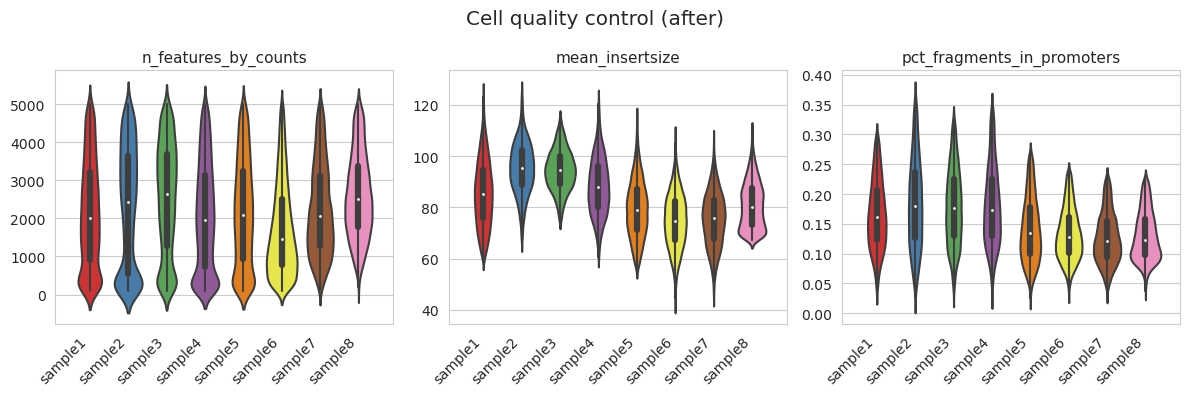

In [58]:
%matplotlib inline 

#Plot violins and sliders
figure, slider_dict = quality_violin(adata, columns=obs_columns,
                                     groupby=condition_column,
                                     which="obs", ncols=3,
                                     global_threshold = global_threshold,
                                     title="Cell quality control (after)",
                                     save=tree.qc_plots + "cell_filtering_final.png")
figure 

## 8. save anndata

In [59]:
adata_output = tree.qc_anndata
adata.write(filename=adata_output)

In [60]:
tree.qc_dir

'/mnt/workspace/jdetlef/ext_ana/processed/all/qc'

In [61]:
import os
import shutil
repo_path = os.getcwd()
notebook_name = '2_QC.ipynb'
notebook_path = os.path.join(repo_path, notebook_name)
notebook_copy = os.path.join(tree.qc_dir , notebook_name)
shutil.copyfile(notebook_path, notebook_copy)

'/mnt/workspace/jdetlef/ext_ana/processed/all/qc/2_QC.ipynb'